# Exercise 3: Ensemble of Batman Trees
Start by splitting the data into a training of 9000 images and test set of 1000 examples each at random.

The subsets should be constructed using the bootstrap technique, which in short means that we should
create new training sets for each individual decision tree in the following manner: sample 5000 training
samples with replacement from the training data (that means any sample may be chosen more than once).
This means that for instance x1 is a subset of 5000 training samples, but most likely there are several which
are duplicates. Thus, you will create x1, x2, ..., x100 and the corresponding y1, y2, ..., y100.

In [52]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

data = pd.read_csv('./../resources/datasets/bm.csv', header=None)

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=9000, test_size=1000, random_state=1945, shuffle=True)

rng = np.random.default_rng()

n = 5000
r = np.zeros([n, 100], dtype=int)
XX = np.zeros([n, 2 ,100])

for i in range (100):
    r[:,i] = rng.choice(n, size=n, replace=True)
    XX[:,:,i] = X_train[r[:,i], :]


Train each of 100 decision trees on the corresponding dataset and combine prediction of the 100 models in majority vote to use as a classifier.

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import mode

individual_predictions = []
trained_trees = []

for i in range(100):
    tree = DecisionTreeClassifier()

    tree.fit(XX[:, :, i], y_train[r[:, i]])
    
    y_pred = tree.predict(X_test)
    
    individual_predictions.append(y_pred)
    trained_trees.append(tree)

individual_predictions = np.array(individual_predictions)
ensemble_predictions = mode(individual_predictions, axis=0).mode
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
individual_accuracies = [accuracy_score(y_test, pred) for pred in individual_predictions]
average_individual_accuracy = np.mean(individual_accuracies)



In [79]:
import numpy as np

ensemble_accuracy_perc = round(ensemble_accuracy * 100, 1)
average_individual_accuracy_perc = round(average_individual_accuracy * 100, 1)

print(f"Ensemble Model Accuracy: {ensemble_accuracy_perc}%")
print(f"Average Individual Tree Accuracy: {average_individual_accuracy_perc}%")
print(f"Improvement: {(ensemble_accuracy_perc - average_individual_accuracy_perc):.1f}%")
print()

max_accuracy = max(individual_accuracies)
min_accuracy = min(individual_accuracies)

print(f"Maximum Individual Tree Accuracy: {max_accuracy * 100:.1f}%")
print(f"Minimum Individual Tree Accuracy: {min_accuracy * 100:.1f}%\n")

# Calculate log odds
ensemble_log_odds = np.log(ensemble_accuracy / (1 - ensemble_accuracy))
average_individual_log_odds = np.log(average_individual_accuracy / (1 - average_individual_accuracy))
min_individual_log_odds = np.log(min_accuracy / (1 - min_accuracy))

# Calculate improvement in log odds
log_odds_improvement_ensemble_vs_average = ensemble_log_odds - average_individual_log_odds
log_odds_improvement_ensemble_vs_min = ensemble_log_odds - min_individual_log_odds

# Calculate improvement in percentage
log_odds_improvement_percentage_ensemble_vs_average = (log_odds_improvement_ensemble_vs_average / average_individual_log_odds) * 100
log_odds_improvement_percentage_ensemble_vs_min = (log_odds_improvement_ensemble_vs_min / min_individual_log_odds) * 100

print(f"Ensemble Log Odds: {ensemble_log_odds:.4f}")
print(f"Average Individual Log Odds: {average_individual_log_odds:.4f}")
print(f"Minimum Individual Log Odds: {min_individual_log_odds:.4f}")
print()
print(f"Improvement in Log Odds (Ensemble vs Average): {log_odds_improvement_ensemble_vs_average:.4f}")
print(f"Improvement in Log Odds (Ensemble vs Average) (%): {log_odds_improvement_percentage_ensemble_vs_average:.2f}%")
print(f"Improvement in Log Odds (Ensemble vs Min): {log_odds_improvement_ensemble_vs_min:.4f}")
print(f"Improvement in Log Odds (Ensemble vs Min) (%): {log_odds_improvement_percentage_ensemble_vs_min:.2f}%\n")



Ensemble Model Accuracy: 97.3%
Average Individual Tree Accuracy: 96.0%
Improvement: 1.3%

Maximum Individual Tree Accuracy: 97.4%
Minimum Individual Tree Accuracy: 94.7%

Ensemble Log Odds: 3.5845
Average Individual Log Odds: 3.1742
Minimum Individual Log Odds: 2.8830

Improvement in Log Odds (Ensemble vs Average): 0.4104
Improvement in Log Odds (Ensemble vs Average) (%): 12.93%
Improvement in Log Odds (Ensemble vs Min): 0.7015
Improvement in Log Odds (Ensemble vs Min) (%): 24.33%



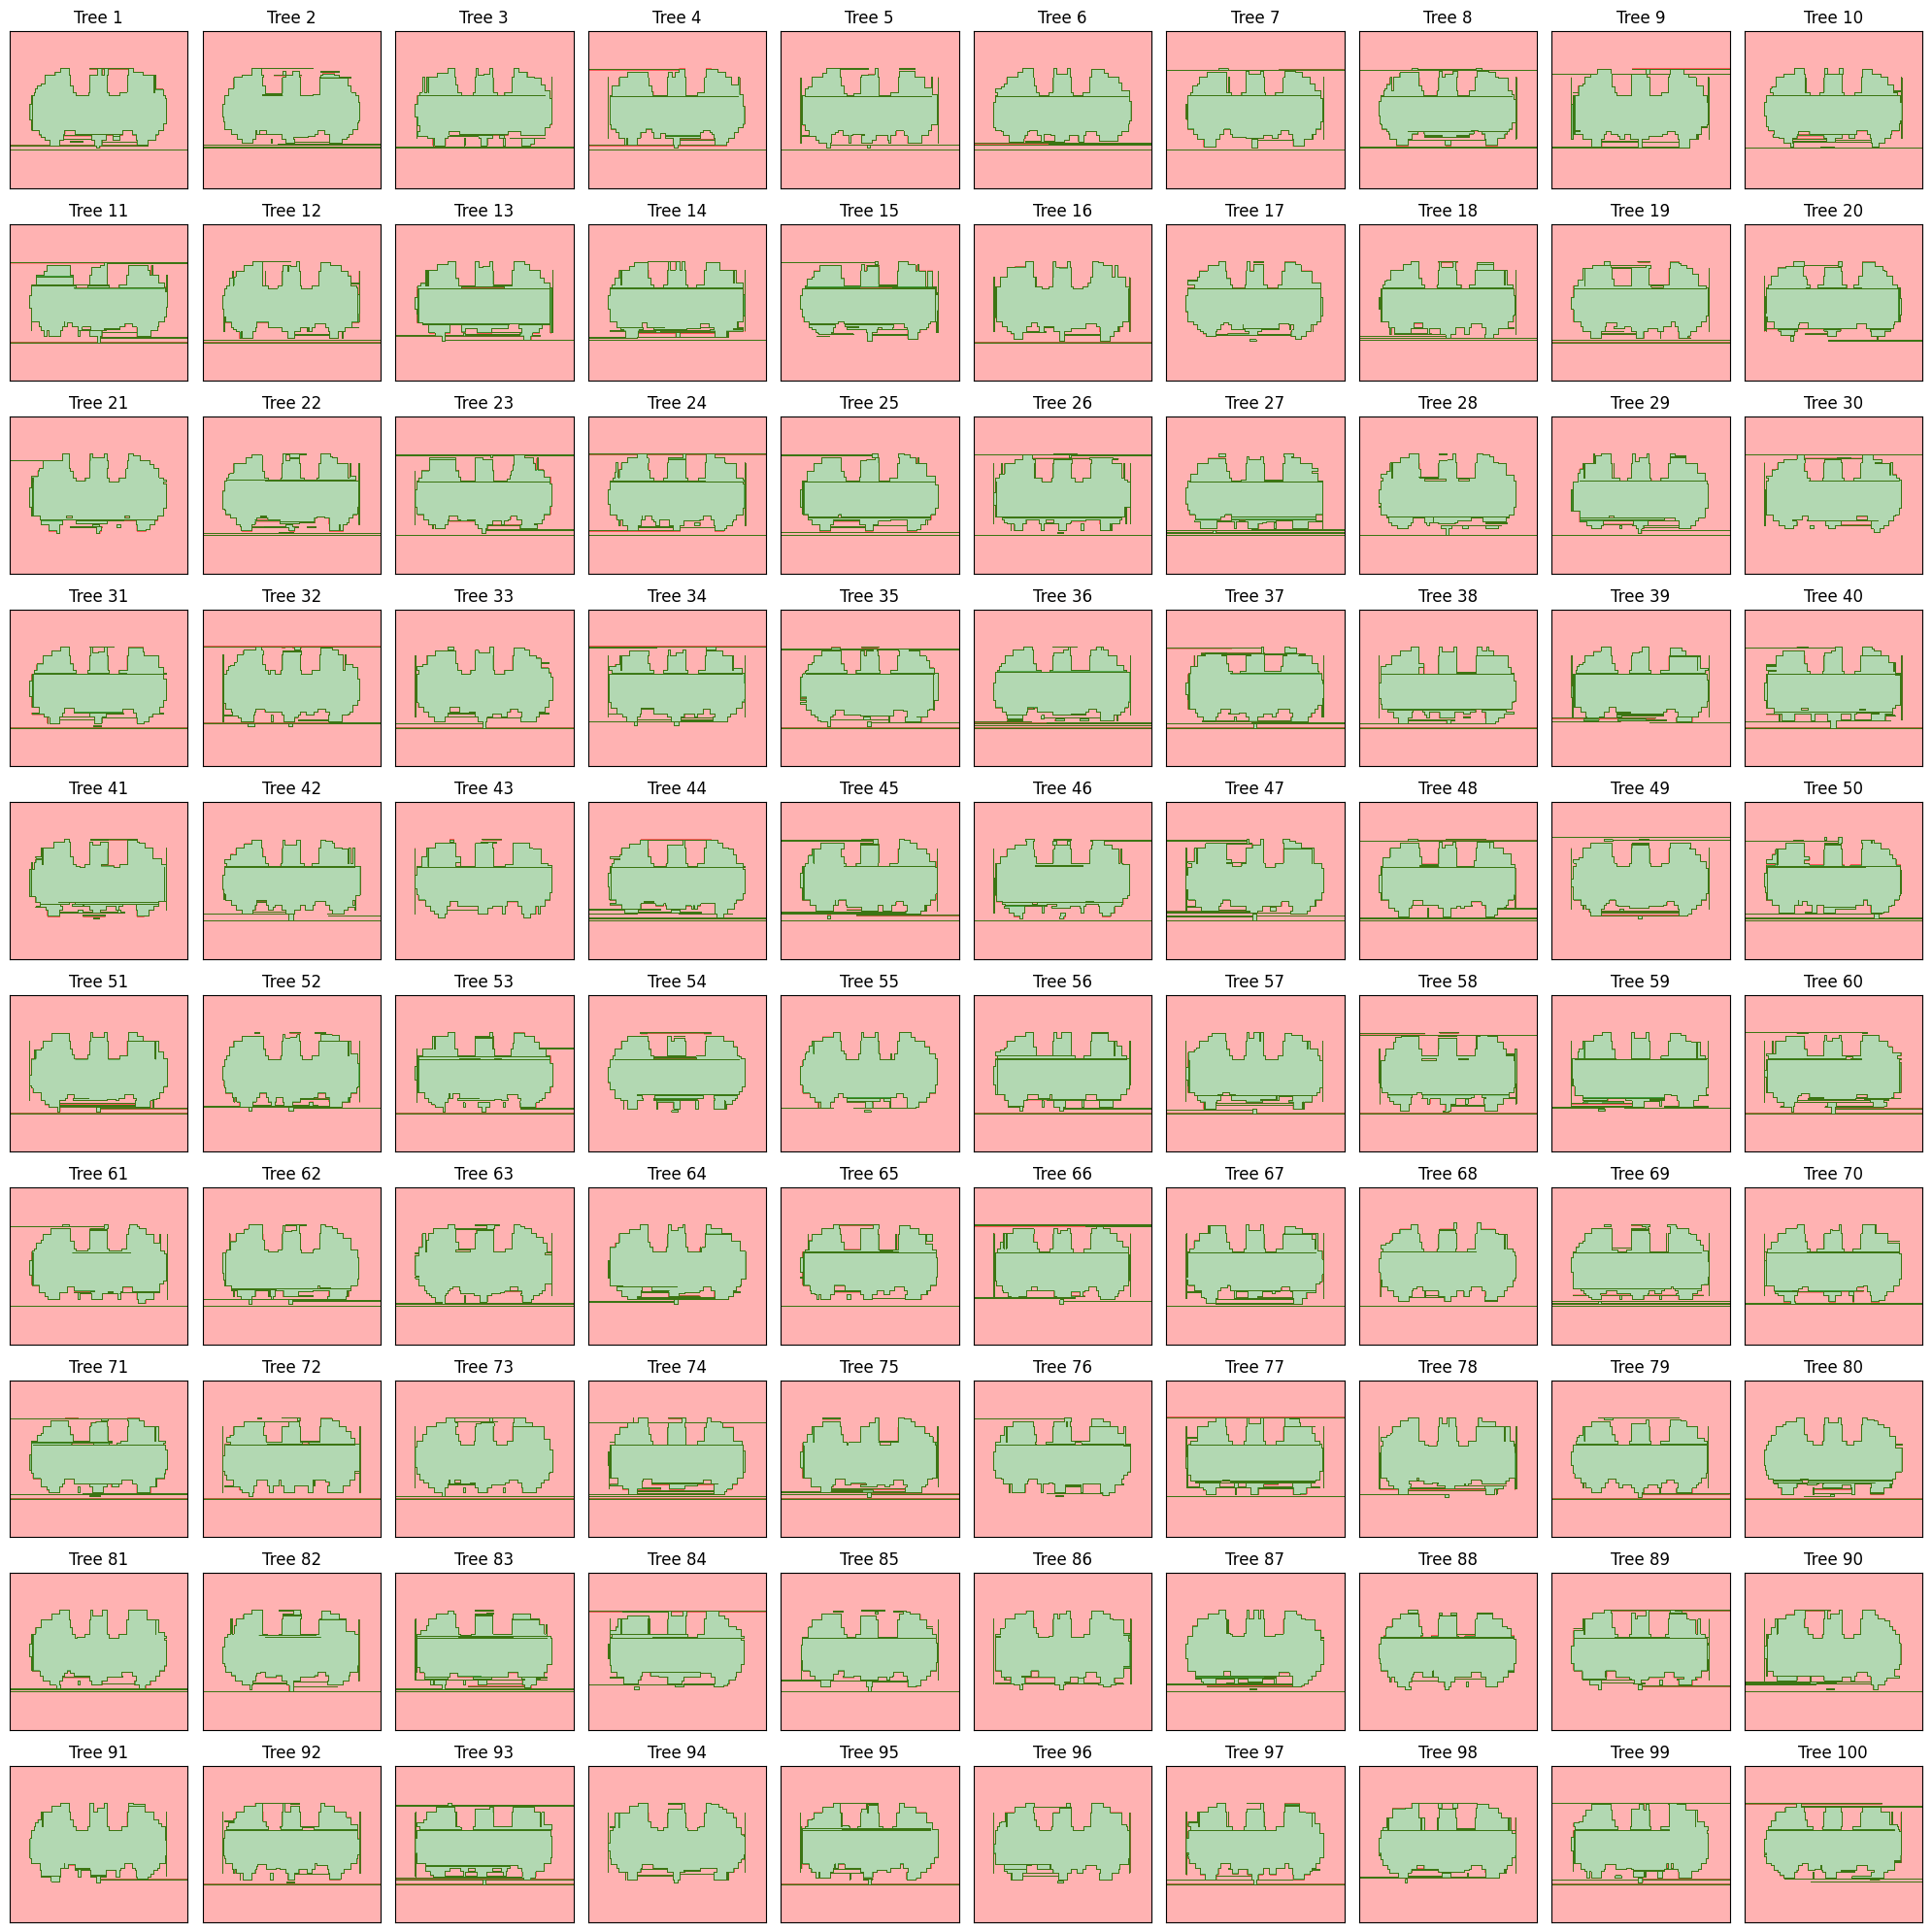

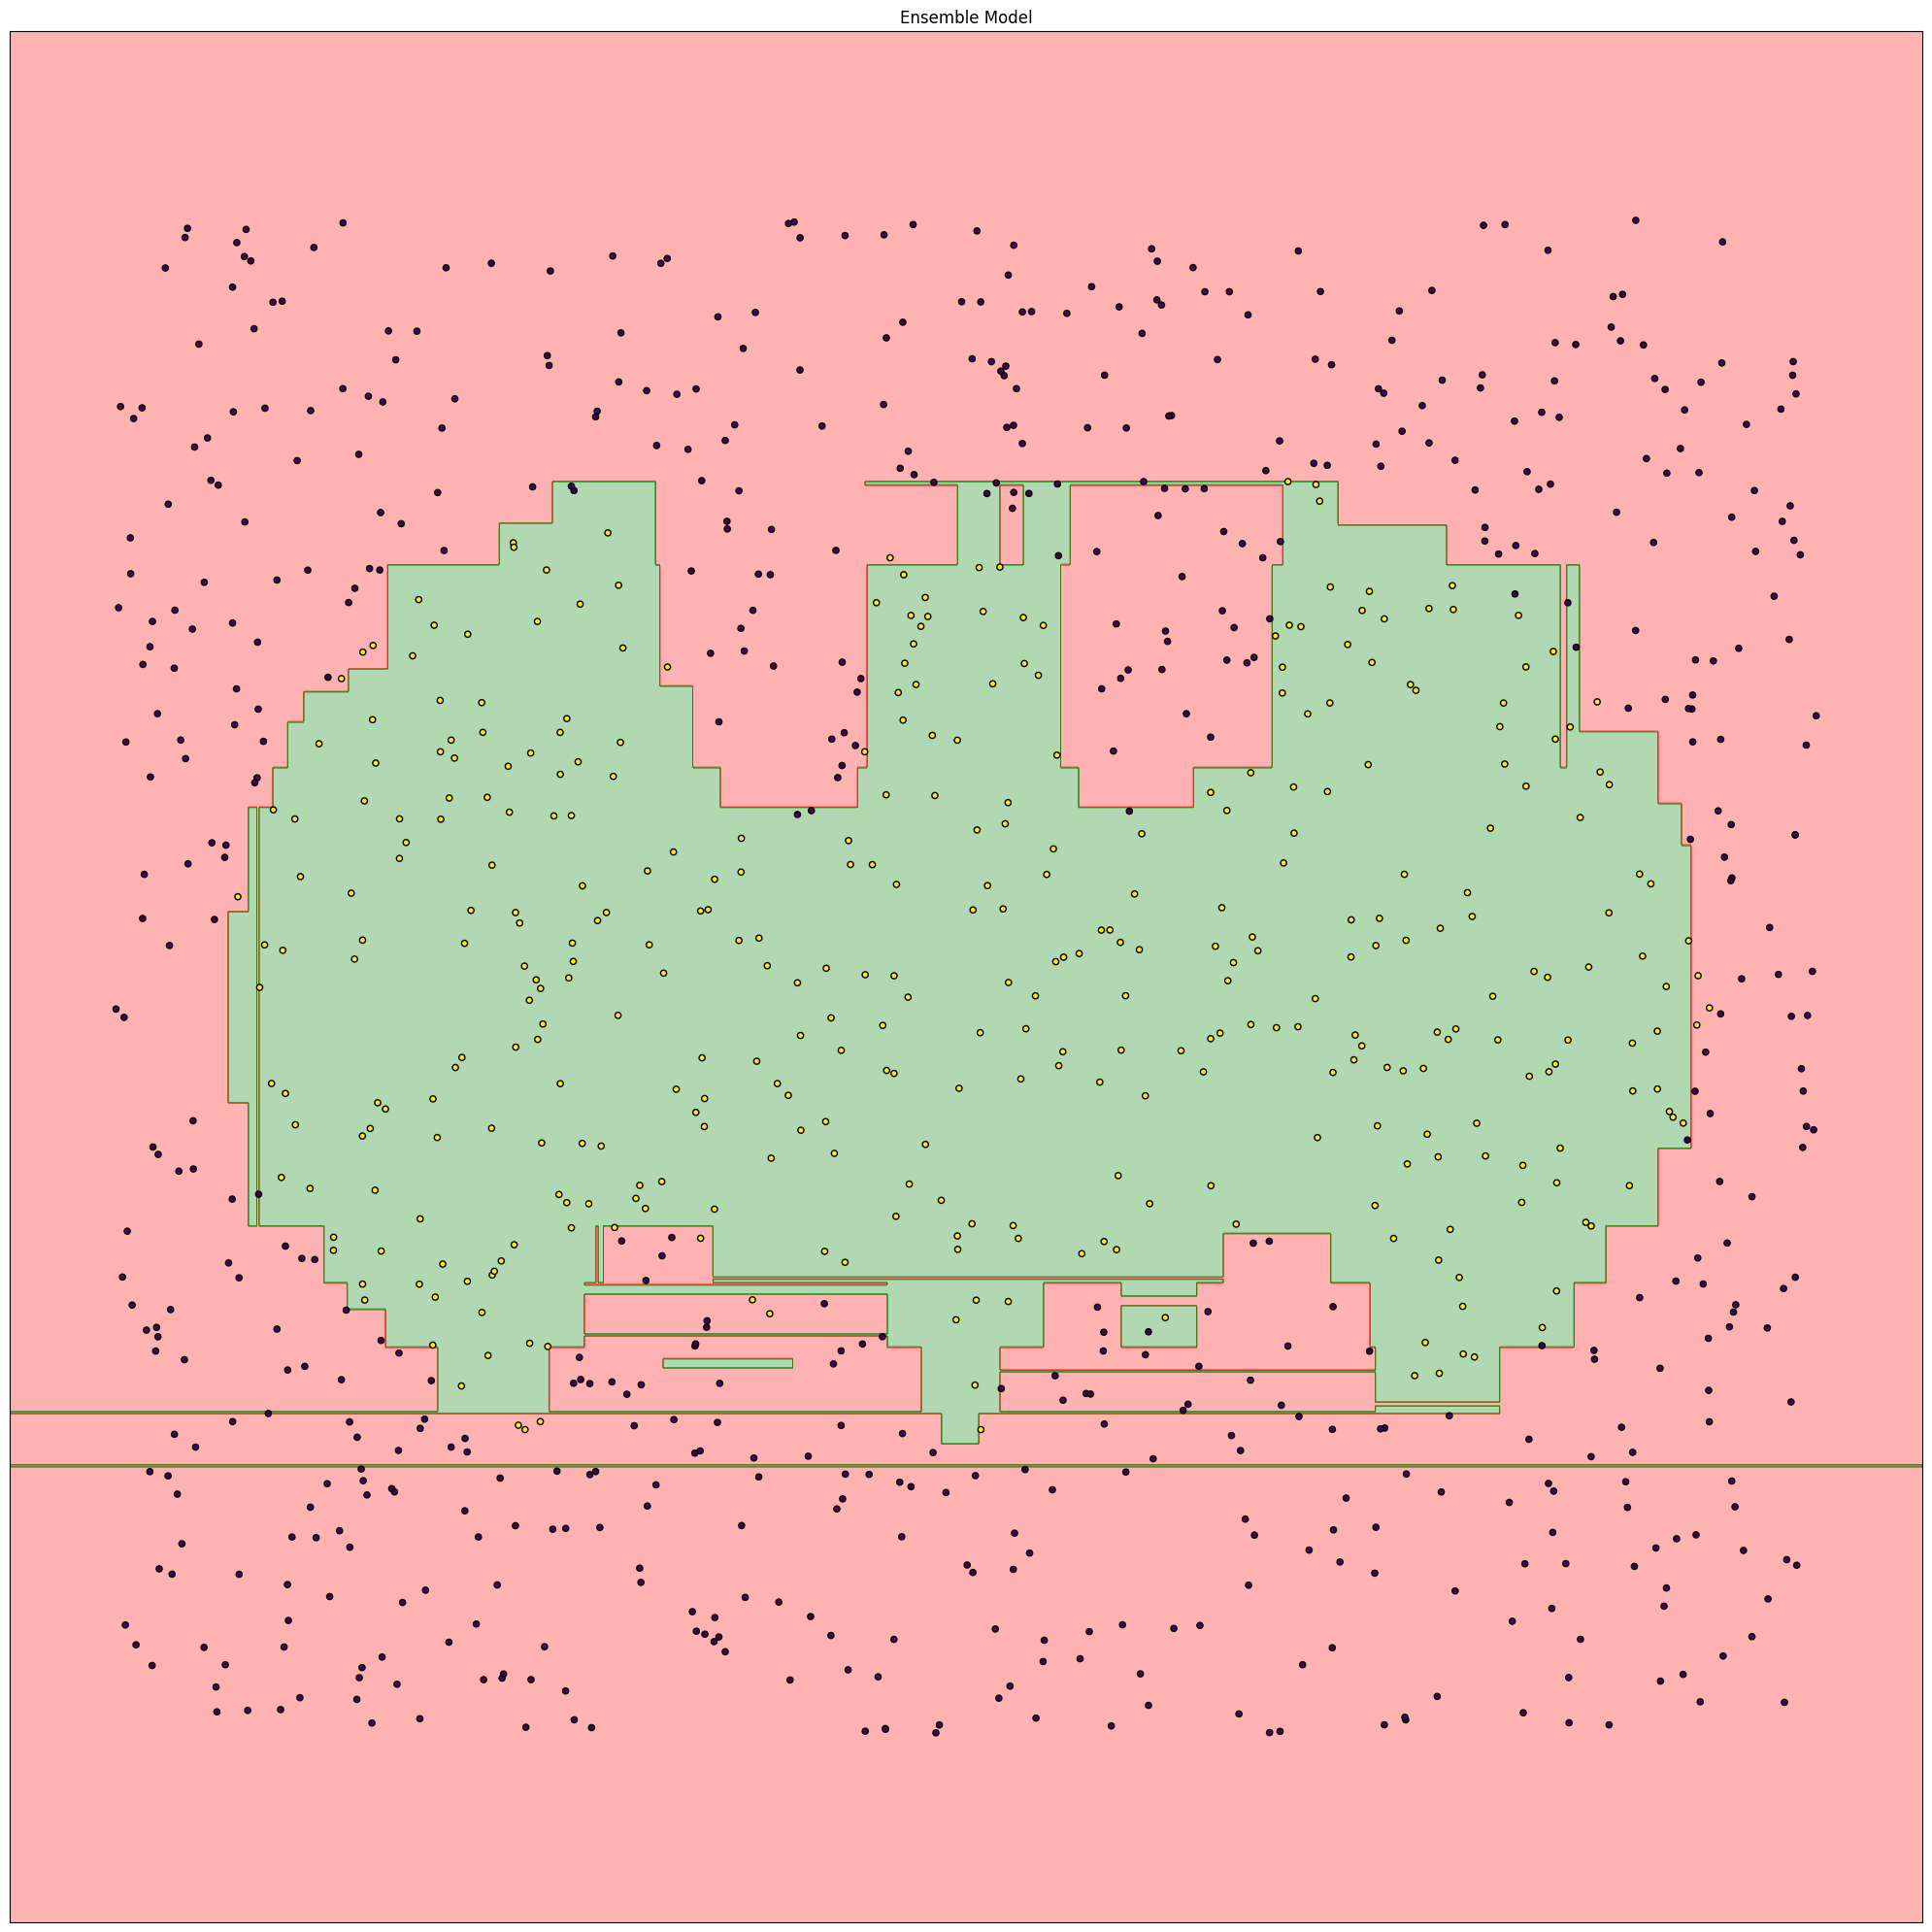

In [85]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y, ax, title, show_points=True):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(('red', 'green')))
    if show_points:
        ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([])

fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.ravel()

# Plot each individual tree's decision boundary
for i, model in enumerate(trained_trees):
    plot_decision_boundary(model, X_test, y_test, axes[i], f"Tree {i + 1}", show_points=False)

plt.tight_layout()
plt.show()

# Create a separate figure for the ensemble model
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot the ensemble model decision boundary using the majority vote predictions
plot_decision_boundary(trained_trees[0], X_test, y_test, ax, "Ensemble Model", show_points=True)

plt.tight_layout()
plt.show()


# Discussion
As observed from the accuracy and log odds printed above, random forest is an effective technique for reducing variance. It provides more stable results across different shuffles. With the current seed, the minimum accuracy for an individual tree was 94.7%. If one is unlucky with the shuffle when working with individual trees, it can lead to a less efficient model. Despite an average accuracy of 96% across 100 trees, the random forest method provided a notable 1.3% increase, resulting in 97.3% accuracy. While this might seem insignificant, it's important to remember that achieving a model performance of at least 90% accuracy is relatively straightforward. However, as accuracy approaches 100%, difficulty of further improvements grows exponentially. Therefore, relative improvements are often assessed in terms of log odds rather than percentage increases in accuracy.

In terms of log odds, our random forest achieved a 12.93% improvement compared to the average accuracy of individual trees and an impressive 24.33% improvement compared to the worst-performing individual tree. This demonstrates the method's effectiveness in reducing variance and preventing overfitting.

The main downside of this method, however, is its computational intensity. Training a single tree using 9000 instances from the training dataset is much faster compared to training 100 trees, each with 5000 randomly sampled instances, resulting in a total of half a million instances being processed.